In [1]:
import os, sys
parent_dir = os.path.abspath('..')
if not parent_dir in sys.path:
    sys.path.append(parent_dir)

In [2]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from dotenv import dotenv_values

In [ ]:
config = dotenv_values(".env")

REKOG_INFERENCE_ARN = config['REKOG_INFERENCE_ARN']
session = boto3.Session(profile_name=config['AWS_PROFILE'])
rekog = session.client('rekognition')
rekog, REKOG_INFERENCE_ARN

In [8]:
def detect_objects(rekog_client, project_inference_arn, image_path):
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    try:
        response = rekog_client.detect_custom_labels(
            ProjectVersionArn=project_inference_arn,
            Image={
                'Bytes': image_bytes,
            },
            MaxResults=10,
            MinConfidence=65.0
        )
        return response
    except rekog_client.exceptions.ResourceNotReadyException as e:
        print(e)
        return {'CustomLabels':[]}

def convert_bbox_to_rect(bbox, image):
    width, height = image.size
    left = width * bbox['Left']
    top = height * bbox['Top']
    width = width * bbox['Width']
    height = height * bbox['Height']
    right = left + width
    bottom = top + height
    return (left, top, width, height)

def get_detected_labels(response):
    # return labels with bouding boxes
    detected_labels = []
    for label in response['CustomLabels']:
            detected_labels.append({
                'label': label['Name'],
                'confidence': label['Confidence'],
                'bbox': label['Geometry']['BoundingBox']
            })
    return detected_labels

In [ ]:
image_path = '../images/test/MIXED/11.jpg'
response = detect_objects(rekog, REKOG_INFERENCE_ARN, image_path)
print(len(response['CustomLabels']))

person-masked-medical 86.52899932861328
person-masked-medical 81.13099670410156
person-masked-medical 75.75700378417969
person-masked-medical 69.8479995727539


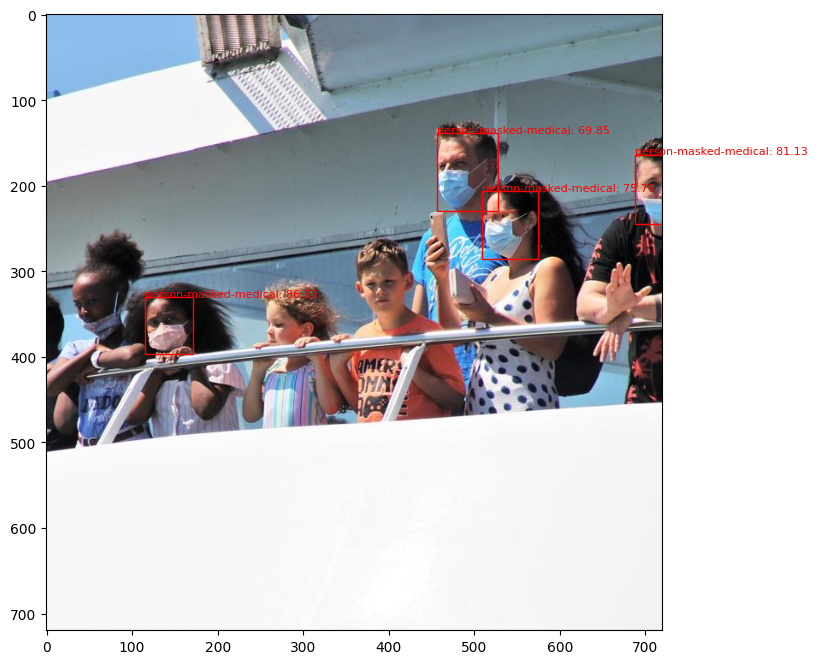

In [22]:
image = Image.open(image_path)
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)
for obj in get_detected_labels(response):
    bbox = convert_bbox_to_rect(obj['bbox'], image)
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=1)
    ax.text(bbox[0], bbox[1], f"{obj['label']}: {obj['confidence']:.2f}", fontsize=8, color='red')
    ax.add_patch(rect)
    print(obj['label'], obj['confidence'])
    